# **A serie of statistical likelihood test for sed library improvement**

We are comparing two **non-nested models** of sed's photometry varying over less or more free parameters. To do so, we computed the likelihood value (Chi2) of N sources to both of these models, and use statistical tests --suitables to compare non-nested models-- to find which one is better. 

## **Initialisation**

In [235]:
### Libs ###
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logsumexp
from scipy.stats import norm
from lephare import statsplot as lsp

%matplotlib inline

In [236]:
### Load files ###
base_dir = os.path.abspath(os.path.join(os.getcwd(), '../..')) #change to your lephare base_dir
path_A = os.path.join(base_dir, 'training_stats/simulation_catalogs/star_gal/DESstars_Buzzard_PICKLES_DES.out')
path_B = os.path.join(base_dir, 'training_stats/simulation_catalogs/star_gal/DESstars_BT_DES_full.out')
# path_A = os.path.join(base_dir, 'training_stats/simulation_catalogs/star_gal/DC1_Buzzard_PICKLES_LSST.out')
# path_B = os.path.join(base_dir, 'training_stats/simulation_catalogs/star_gal/DC1_Buzzard_BT_LSST.out')

tab_A = lsp.lephare_to_pandas(path_A)
tab_B = lsp.lephare_to_pandas(path_B)
### Clean error values
# tab_A = tab_A[tab_A['ERR_MAG_OBS0'] < 0.002]
# tab_B = tab_B[tab_B['ERR_MAG_OBS0'] < 0.002]

In [237]:
def join_tables(base_df, tables, how="outer", ignore=None, put_match_first=True, drop_unmatched=True, indicator=False):
    # Normalize single join instruction to list
    if isinstance(tables, tuple) and len(tables) == 3:
        tables = [tables]

    result = base_df.copy()
    match_columns = []

    for other_df, base_col, other_col in tables:
        result = result.merge(
            other_df,
            how=how,
            left_on=base_col,
            right_on=other_col,
            indicator=indicator
        )
        match_columns.append(base_col)
    # Drop unmatched rows (forces inner join behavior)
    if drop_unmatched:
        for col in match_columns:
            result = result[result[col].notna()]
    
    if indicator:
        result = result[(result['_merge'] == 'left_only') | (result['_merge'] == 'both')]
        result["present"] = (result['_merge'] == "both").astype(int)
        result = result.drop(columns=["_merge"])
    # Drop ignored columns
    if ignore:
        result = result.drop(columns=[c for c in ignore if c in result.columns])

    # Move match columns to front
    if put_match_first:
        # Keep order if multiple match columns
        front_cols = [c for c in match_columns if c in result.columns]
        other_cols = [c for c in result.columns if c not in front_cols]
        result = result[front_cols + other_cols]

    return result


In [238]:
tab_AB = join_tables(tab_A[['IDENT', 'CHI_STAR', 'NBAND_USED']].rename(columns={"CHI_STAR": "CHI_STAR_A", "NBAND_USED": "NBAND_USED_A"}),
                     [(tab_B[['IDENT', 'CHI_STAR', 'NBAND_USED']].rename(columns={"CHI_STAR": "CHI_STAR_B", "NBAND_USED": "NBAND_USED_B"}), 'IDENT', 'IDENT')],
                     how='right')

In [239]:
### Initialize parameters and Chi2 list ###
kA = 2 # Teff, alpha (normalisation)[(tab_B[['IDENT', 'CHI_STAR']]
kB = 4 # Teff, logg, FeH, alpha (normalisation)
ndata = 5   # ugriz

## **AIC**

$\mathrm{AIC}_{m,i}=\chi^2_{m,i}+2k_m$

Total AIC over all stars:

$\mathrm{AIC^{tot}}_m = \sum_i \mathrm{AIC}_{m,i}$

The model with the smallest $\mathrm{AIC^{tot}}_m$ is the prefered one (in overall).


In [240]:
def AIC_total(chi2_min, k):
    """
    Compute total AIC over all sources.

    Parameters
    ----------
    chi2_min : array-like
        Minimum chi² values for each source for a given model.
    k : int
        Number of free parameters of the model.

    Returns
    -------
    float
        Total AIC for the model.
    """
    chi2_min = np.asarray(chi2_min)
    AIC = chi2_min + 2 * k
    return AIC.sum(), AIC

In [241]:
# --- AIC ---
AICtot_A, AIC_A = AIC_total(tab_AB['CHI_STAR_A'], kA)
AICtot_B, AIC_B = AIC_total(tab_AB['CHI_STAR_B'], kB)

print("ΔAIC =", (AICtot_A - AICtot_B)/len(tab_AB))

ΔAIC = 2312.5805316192627


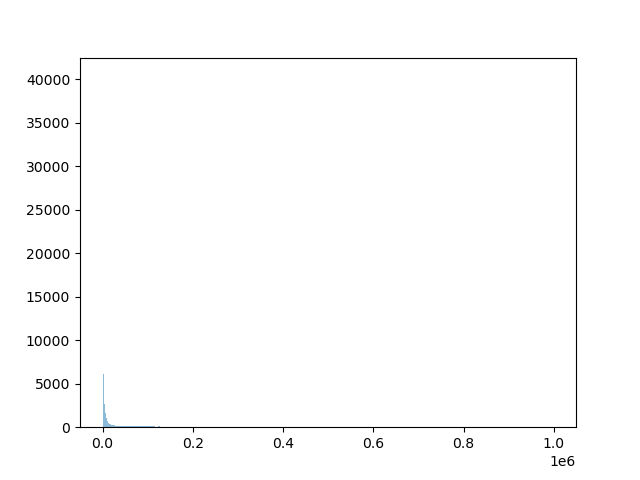

In [246]:
%matplotlib widget
plt.figure()
# plt.hist(AIC_A-AIC_B, bins =np.arange(-100,900,1), alpha = 0.5) #The peak at -4 is due to no imrovment on very good fits
# plt.hist(AIC_A[(AIC_A-AIC_B)==-4], bins =np.arange(0, 1000000,1000), alpha = 0.5)
plt.hist(AIC_A, bins =np.arange(0, 1000000,1000), alpha = 0.5)
# plt.hist(AIC_B, bins =np.arange(0, 1000000,1000), alpha = 0.5)
plt.show()

## **BIC**

$\mathrm{BIC}_{m,i}=\chi^2_{m,i}+k_m\ln(n_{data})$

Total AIC over all stars:

$\mathrm{BIC^{tot}}_m = \sum_i \mathrm{BIC}_{m,i}$

The model with the smallest $\mathrm{BIC^{tot}}_m$ is the prefered one (in overall).

In [196]:
def BIC_total(chi2_min, n, k):
    """
    Compute total BIC over all sources.

    Parameters
    ----------
    chi2_min : array-like
        Minimum chi² for each source.
    n : int or array-like
        Number of data points per source (e.g. 6 for ugrizy).
        If array-like, must match len(chi2_min).

    Returns
    -------
    float
        Total BIC for the model.
    """
    chi2_min = np.asarray(chi2_min)

    if np.isscalar(n):
        n = np.full_like(chi2_min, n, dtype=float)
    else:
        n = np.asarray(n)
        if len(n) != len(chi2_min):
            raise ValueError("n must be scalar or same length as chi2_min")

    BIC = chi2_min + k*np.log(n)  # the 'k * ln(n)' term should be applied outside
    # NOTE: this returns ONLY the data-dependent term;
    # the caller must add k * sum(ln(n)) for each model.
    return BIC.sum()

In [198]:
# --- BIC ---
BICA = BIC_total(tab_AB['CHI_STAR_A'], tab_AB['NBAND_USED_A'],kA)
BICB = BIC_total(tab_AB['CHI_STAR_B'], tab_AB['NBAND_USED_B'],kB)

print("ΔBIC =", (BICA - BICB)/len(tab_AB))

ΔBIC = 2313.3616557944106


## **Vuong**

For each star:

$m_i = -\frac{1}{2}​(\chi^2_{l,i} - \chi^2_{m,i})$

Then 

$\overline{m} = \frac{1}{n}\sum^n_{i=1}m_i$ and $s_m = \sqrt{\frac{1}{n}\sum^n_{i=1}(m_i-\overline{m})^2}$

To give the Vuong test statistic:

$V=\frac{\sqrt{n}\overline{m}}{s_m}$

 - If $V>0$: prefer model l.
 - If $V<0$: prefer model m.
 - If $|V| < 2$: Fail to reject

In [275]:
def Vuong_test(chi2_A, chi2_B, kA, kB):
    """
    Compute Vuong's non-nested model comparison statistic.

    Parameters
    ----------
    chi2_A : array-like
        Minimum chi² values under model 0 (one per source)
    chi2_B : array-like
        Minimum chi² under model 1 (one per source)

    Returns
    -------
    V : float
        Vuong V-statistic (asymptotically N(0,1))
    p_value : float
        Two-sided p-value for V
    """
    chi2_A = np.asarray(chi2_A)
    chi2_B = np.asarray(chi2_B)

    if len(chi2_A) != len(chi2_B):
        raise ValueError("chi2_A and chi2_B must have same length")

    # log-likelihood ratio per star (Gaussian errors)
    l = -0.5 * (chi2_A - chi2_B)

    l_mean = l.mean()
    s = l.std()
    N = len(l)

    V = np.sqrt(N) * l_mean / s
    
    V_adjusted = V - (kA-kB)*np.log(N)/(2*s*np.sqrt(N))

    p_value = 2 * (1 - norm.cdf(abs(V)))

    return V_adjusted, p_value

In [276]:
# --- Vuong ---
V, p = Vuong_test(tab_AB['CHI_STAR_A'], tab_AB['CHI_STAR_B'], kA=2, kB=4)#[tab_AB['CHI_STAR_A']<10000]
print("Vuong V =", V, "p =~", p)

Vuong V = -66.7457670910587 p =~ 0.0


## **Bayes test** (not finished yet)

It is possible to compare the efficient of two non-nested models who have the same purpose. To do this we can compute the **Odds ratio** of the two sed library model. 

The Bayes factor is the ratio of two marginal likelihoods; that is, the likelihoods of two statistical models integrated over the prior probabilities of their parameters. (https://en.wikipedia.org/wiki/Bayes_factor)

The posterior probability $P(M|D)$ of a model M given data D is given by Bayes' theorem:

$P(M∣D)=\frac{P(D∣M)P(M)}{P(D)}$


The Odds ratio is given by:

$Odds(M_1​:M_0​)=\frac{P(D∣M_0​)}{P(D∣M_1​)}\times \frac{P(M_0​)}{P(M_1​)​}$

where

$\frac{P(D∣M_0​)}{P(D∣M_1​)}$ is the **Bayes factor**.

and

$\frac{P(M_0​)}{P(M_1​)​}$ is the **prior odds** which is equal to 1 if no prior is imposed between the two models.

Now if we have many sources fitted to two models composed both of several seds, the Bayes factor is:

$B = \frac{Z^1}{Z^2}$ or $ln(B)=\ln(Z^2)-\ln(Z^1)$

where Z is the marginal likelihood:

$Z_i=\sum_{j} \mathcal{L}_{ij}\pi_i$ or $\log Z_i = \mathrm{logsumexp}(-\frac{1}{2}\chi^2_{ij}+\log  \pi_j)$ for one source.

So in total $\log Z=\sum_i\log Z_i$

Thus the total Bayes factor is:
$\ln B=\ln Z^2-\ln Z^1$


### **1. Initialization**

In [ ]:
### Load Chi2 files ###
#It is necessary to have the full chi2 output to do the Bayes test
#(chi2 corresponding to each fit, for each onsource)
def load_chi2_table(filename, max_rows=None):
    """
    File with :
      - column 0 : Id of the source (int)
      - column 1..N : chi2
    """
    data = np.loadtxt(filename, max_rows=max_rows)
    if max_rows == 1:
        source_ids = data[0].astype(np.int64)
        chi2_matrix = data[1:]
    else:
        source_ids = data[:, 0].astype(np.int64)
        chi2_matrix = data[:, 1:]
    return source_ids, chi2_matrix

base_dir = os.path.abspath(os.path.join(os.getcwd(), '../..')) #change to your lephare base_dir
file_libA = os.path.join(base_dir, 'training_stats/simulation_catalogs/star_gal/PDFs/DESstars_Buzzard_PICKLES_DES_PDFstar.prob')
file_libB = os.path.join(base_dir, 'training_stats/simulation_catalogs/star_gal/PDFs/DESstars_BT_DES_full_PDFstar.prob')

idsA, chi2_A = load_chi2_table(file_libA, max_rows=1000)
idsB, chi2_B = load_chi2_table(file_libB, max_rows=1000)

### We only use sources present in both chi2 files ###
common_ids, idxA_common, idxB_common = np.intersect1d(
    idsA, idsB, return_indices=True
)

try:
    print(f"A: {len(idsA)}")
    print(f"B: {len(idsB)}")
    print(f"common: {len(common_ids)}")
except:
    print()
chi2_A = chi2_A[idxA_common]
chi2_B = chi2_B[idxB_common]

#check dimensions
n_sources = chi2_A.shape[0]
n_templatesA = chi2_A.shape[1]
n_templatesB = chi2_B.shape[1]

### **2. Compute log-evidence**

For each source $i$, we compute the marginal log-evidence of a template library:

$\log Z_i = \mathrm{logsumexp}\left( -\tfrac{1}{2}\chi^2_{ij} + \log \pi_j \right)$

where:
- $\chi^2_{ij}$ is the chi-square value between source $i$ and template $j$,
- $\pi_j$ is the prior over templates (uniform by default),
- logsumexp ensures numerical stability for large $\chi^2$.

This represents the total probability of explaining source $i$ using all templates in the library.


Assuming all sources are independent, the total evidence of a library $\mathcal{M}$ is:

$\log Z^{(\mathcal{M})} = \sum_i \log Z_i^{(\mathcal{M})}$.

This is the global likelihood of the entire library given all observed sources.


In [37]:
### Function to give priors to templates ###
#For the moment we use uniform prior
def uniform_prior(n_templates):
    return np.ones(n_templates) / n_templates

### Marginal log-evidence ###
def compute_log_evidence(chi2_matrix, prior=None):
    n_sources, n_templates = chi2_matrix.shape

    if prior is None:
        prior = uniform_prior(n_templates)

    log_prior = np.log(prior)

    # log-likelihood
    logL = -0.5 * chi2_matrix

    # log-evidence for each source
    logZ_i = logsumexp(logL + log_prior, axis=1)

    # somme totale
    logZ_total = np.sum(logZ_i)

    return logZ_total, logZ_i

logZ_A, logZ_i_A = compute_log_evidence(chi2_A)
logZ_B, logZ_i_B = compute_log_evidence(chi2_B)

### **3. Bayes factors**

To compare template libraries A and B, we use the Bayes factor:

$B_{\mathrm{BA}} = \frac{Z^{(B)}}{Z^{(A)}}$,

with its log form:

$\ln B = \log Z^{(B)} - \log Z^{(A)}$.

A positive $\ln B$ indicates preference for library B; a negative value favors library A.

A per-source Bayes factor can also be computed:

$\ln B_i = \log Z_{i,B} - \log Z_{i,A}$,

which indicates how much each individual source contributes to the overall model preference.


In [38]:
###
lnB_total = logZ_B - logZ_A
B_total = np.exp(lnB_total)

# Bayes factor per source
B_i = np.exp(logZ_i_B - logZ_i_A)
### Results ###
print("\n=== RÉSULTATS ===")
print(f"N sources : {n_sources}")
print(f"LogZ total A : {logZ_A:.3f}")
print(f"LogZ total B : {logZ_B:.3f}")
print(f"Individual mean ln(B_i) : {np.mean(np.log(B_i)):.3f}")
print(f"Individual median ln(B_i) : {np.median(np.log(B_i)):.3f}")
print(f"Exemples B_i (10 premières sources) : {B_i[:10]}")


=== RÉSULTATS ===
N sources : 1000
LogZ total A : -27946941.774
LogZ total B : -26927013.706
Individual mean ln(B_i) : nan
Individual median ln(B_i) : 164.885
Exemples B_i (10 premières sources) : [1.31951951e+001             inf 4.49505821e+062 3.00633475e+024
 1.00000000e+000 1.00000000e+000 8.54832590e+055 9.97689250e+094
 2.36603442e+176             inf]


/tmp/ipykernel_15681/2672218869.py:3: RuntimeWarning: overflow encountered in exp
  B_total = np.exp(lnB_total)
/tmp/ipykernel_15681/2672218869.py:6: RuntimeWarning: overflow encountered in exp
  B_i = np.exp(logZ_i_B - logZ_i_A)
/tmp/ipykernel_15681/2672218869.py:12: RuntimeWarning: divide by zero encountered in log
  print(f"Individual mean ln(B_i) : {np.mean(np.log(B_i)):.3f}")
/home/hallouin/miniconda3/envs/lephare/lib/python3.12/site-packages/numpy/_core/_methods.py:134: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/tmp/ipykernel_15681/2672218869.py:13: RuntimeWarning: divide by zero encountered in log
  print(f"Individual median ln(B_i) : {np.median(np.log(B_i)):.3f}")
